<a href="https://colab.research.google.com/github/Sagnik-Nandi/PDFQueryBot---Chatbot-over-PDFs-using-RAG/blob/main/final%20project/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [3]:
!pip install -qU "langchain[openai]"
!pip install -qU langchain-openai
!pip install -qU langchain-core
!pip install -qU pypdf
!pip install -qU langchain-huggingface # this took 2 min to execute

In [4]:
# !pip install -U transformers accelerate bitsandbytes

## Importing Langchain etc

In [5]:
# if not os.environ.get("OPENAI_API_KEY"):
#   os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

# from langchain.chat_models import init_chat_model

# llm = init_chat_model("gpt-4o-mini", model_provider="openai")


# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [6]:
from langchain import hub
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

## Configuring llama model

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # load_in_8bit=True,  # Use 8-bit quantization for memory efficiency
    device_map="auto",  # Automatically distribute model across available devices
    torch_dtype=torch.float16,  # Use float16 for faster computation
) #13.5 GB size 😢

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

## Pdf loading, splitting and storing in vector database

In [9]:
#Loading
pdf_path = "./ugrulebook.pdf"
loader = PyPDFLoader(pdf_path)
docs = loader.load() # list of pages

In [10]:
total=0
for doc in docs:
    total+=len(doc.page_content)
print("Total number of chararcters: ", total)

Total number of chararcters:  128906


In [11]:
# Splitting
# split a long document into smaller chunks that can fit into your model's context window
# 2 hyperparameters : chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
len(all_splits)

92

In [12]:
# Storing
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])
# took 3 minutes to run on cpu server😢

['584dbbdd-0ff8-4e3f-9349-c4798d684977', 'e0ea42d6-e053-435f-b9f1-5b945b006ee6', 'a7d6ae74-814f-4ccd-bd2e-d03311a34ceb']


# Idk what is this

In [13]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [30]:
from transformers import pipeline
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# prompt = hub.pull("rlm/rag-prompt")

template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use five sentences maximum.
Context:
{context}
Question: {question}
Answer:"""
prompt = PromptTemplate(input_variables=["context", "question"], template=template)


# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         ("human", "{input}"),
#     ]
# )
retriever = vector_store.as_retriever()

qa_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, qa_chain)

# pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, prompt=prompt)
# llm = HuggingFacePipeline(pipeline=pipe)


Device set to use cpu


In [31]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## Idk what is this, but will soon find out

In [25]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

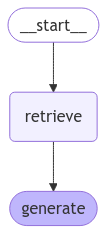

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
response = rag_chain.invoke({"input": "What are the eligibility criteria for applying for a change of branch/ programme?"})
response["answer"]

# result = graph.invoke({"question": "What is the eligibility criteria for applying for a branch/ change ?"})

# print(f'Context: {result["context"]}\n\n')
# print(f'Answer: {result["answer"]}')

KeyError: 'input'